# Introduction

I created this notebook to show what I have learned with stacking and boosting models.
I currently work as a data scientist, but most of my projects don't involve boosting or stacking.

In [4]:
% matplotlib inline

import matplotlib.pyplot as plt

import os

import pandas as pd
import numpy as np
import seaborn as sns

# Loading the data

I do not have any domain knowledge of this challenge, but I have been reading and viewing other kernels.
The following loading and renaming of features is not my own work.

In [8]:
test = pd.read_csv('../input/nomad2018-predict-transparent-conductors/test.csv')
test_id = test.id

train = pd.read_csv('../input/nomad2018-predict-transparent-conductors/train.csv')

train.rename(columns={
    'spacegroup' : 'sg',
    'number_of_total_atoms' : 'Natoms',
    'percent_atom_al' : 'x_Al',
    'percent_atom_ga' : 'x_Ga',
    'percent_atom_in' : 'x_In',
    'lattice_vector_1_ang' : 'a',
    'lattice_vector_2_ang' : 'b',
    'lattice_vector_3_ang' : 'c',
    'lattice_angle_alpha_degree' : 'alpha',
    'lattice_angle_beta_degree' : 'beta',
    'lattice_angle_gamma_degree' : 'gamma',
    'formation_energy_ev_natom' : 'E',
    'bandgap_energy_ev' : 'Eg'}, inplace=True)

test.rename(columns={
    'spacegroup' : 'sg',
    'number_of_total_atoms' : 'Natoms',
    'percent_atom_al' : 'x_Al',
    'percent_atom_ga' : 'x_Ga',
    'percent_atom_in' : 'x_In',
    'lattice_vector_1_ang' : 'a',
    'lattice_vector_2_ang' : 'b',
    'lattice_vector_3_ang' : 'c',
    'lattice_angle_alpha_degree' : 'alpha',
    'lattice_angle_beta_degree' : 'beta',
    'lattice_angle_gamma_degree' : 'gamma',
}, inplace=True)


target = [
    'E',
    'Eg']

variables = [
    'sg',
    'Natoms',
    'x_Al',
    'x_Ga',
    'x_In',
    'a',
    'b',
    'c',
    'alpha',
    'beta',
    'gamma']

all_data = pd.concat((train[variables], test[variables]))

## Retrieve list of elemental Properties

- Many people in the forum commented that adding outside information can add useful features
- The following code adds many features in order to finally add atomic_density and volume

In [9]:
def get_prop_list(path_to_element_data):
    """
    Args:
        path_to_element_data (str) - path to folder of elemental property files
    Returns:
        list of elemental properties (str) which have corresponding .csv files
    """
    return [f[:-4] for f in os.listdir(path_to_element_data)]

# folder which contains element data
path_to_element_data = '../input/elementalproperties/'
# get list of properties which have data files
properties = get_prop_list(path_to_element_data)
print(sorted(properties))

['EA', 'HOMO', 'IP', 'LUMO', 'electronegativity', 'mass', 'rd_max', 'rp_max', 'rs_max']


In [10]:
def get_prop(prop, path_to_element_data):
    """
    Args:
        prop (str) - name of elemental property
        path_to_element_data (str) - path to folder of elemental property files
    Returns:
        dictionary of {element (str) : property value (float)}
    """
    fin = os.path.join(path_to_element_data, prop+'.csv')
    with open(fin) as f:
        all_els = {line.split(',')[0] : float(line.split(',')[1][:-1]) for line in f}
        my_els = ['Al', 'Ga', 'In']
        return {el : all_els[el] for el in all_els if el in my_els}

# make nested dictionary which maps {property (str) : {element (str) : property value (float)}}
prop_dict = {prop : get_prop(prop, path_to_element_data) for prop in properties}
print('The mass of aluminum is %.2f amu' % prop_dict['mass']['Al'])

The mass of aluminum is 26.98 amu


In [11]:
# average each property using the composition

def avg_prop(x_Al, x_Ga, x_In, prop):
    """
    Args:
        x_Al (float or DataFrame series) - concentration of Al
        x_Ga (float or DataFrame series) - concentration of Ga
        x_In (float or DataFrame series) - concentration of In
        prop (str) - name of elemental property
    Returns:
        average property for the compound (float or DataFrame series), 
        weighted by the elemental concentrations
    """
    els = ['Al', 'Ga', 'In']
    concentration_dict = dict(zip(els, [x_Al, x_Ga, x_In]))
    return np.sum(prop_dict[prop][el] * concentration_dict[el] for el in els)

# add averaged properties to DataFrame
for prop in properties:
    all_data['_'.join(['avg', prop])] = avg_prop(all_data['x_Al'], 
                                                 all_data['x_Ga'],
                                                 all_data['x_In'],
                                                 prop)

In [12]:
# calculate the volume of the structure

def get_vol(a, b, c, alpha, beta, gamma):
    """
    Args:
        a (float) - lattice vector 1
        b (float) - lattice vector 2
        c (float) - lattice vector 3
        alpha (float) - lattice angle 1 [radians]
        beta (float) - lattice angle 2 [radians]
        gamma (float) - lattice angle 3 [radians]
    Returns:
        volume (float) of the parallelepiped unit cell
    """
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
                           - np.cos(alpha)**2
                           - np.cos(beta)**2
                           - np.cos(gamma)**2)

# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['alpha', 'beta', 'gamma']
for lang in lattice_angles:
    all_data['_'.join([lang, 'r'])] = np.pi * all_data[lang] / 180
    
# compute the cell volumes 
all_data['vol'] = get_vol(all_data['a'], all_data['b'], all_data['c'],
                          all_data['alpha_r'], all_data['beta_r'], all_data['gamma_r'])

# calculate the atomic density
all_data['atomic_density'] = all_data['Natoms'] / all_data['vol']  

## Imputing/Preprocessing the data for model

Some of the values are actually categorical in Nature and I used that to my advantage.



In [14]:
all_data.head()

,sg,Natoms,x_Al,x_Ga,x_In,a,b,c,alpha,beta,...,avg_EA,avg_electronegativity,avg_rs_max,avg_mass,avg_rd_max,alpha_r,beta_r,gamma_r,vol,atomic_density
0,33,80.0,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,...,-0.200725,1.68500,1.07750,43.009587,2.753750,1.570842,1.570836,1.570826,781.052081,0.102426
1,194,80.0,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,...,-0.200725,1.68500,1.07750,43.009587,2.753750,1.571121,1.570761,2.094439,782.500110,0.102236
2,227,40.0,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,...,-0.228512,1.64750,1.10375,34.995563,2.931875,1.587705,1.590393,0.532648,391.227531,0.102242
3,167,30.0,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,...,-0.270350,1.65250,1.12000,48.940654,2.817500,1.570601,1.571004,2.094425,293.377334,0.102257
4,194,80.0,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,...,-0.184750,1.79875,1.02750,86.633625,2.077500,1.570727,1.570807,2.094208,944.713843,0.084682


> ### Categorical Features
- I noticed after looking through that some of the categorical data can group other features
- I took the categories and plotted a distribution plot of different features grouped by their categories

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


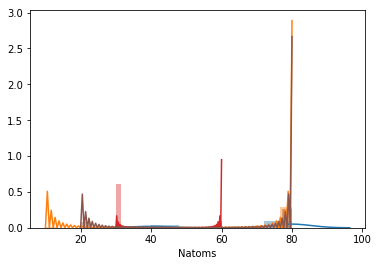

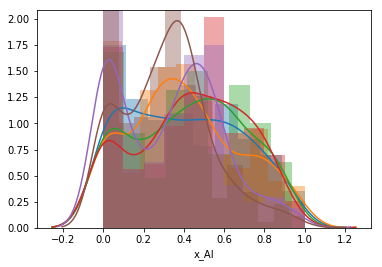

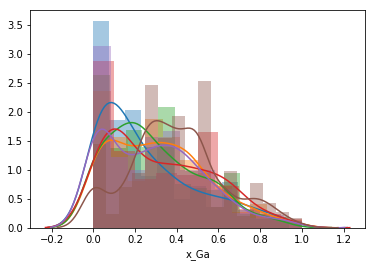

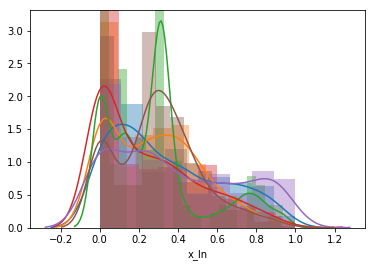

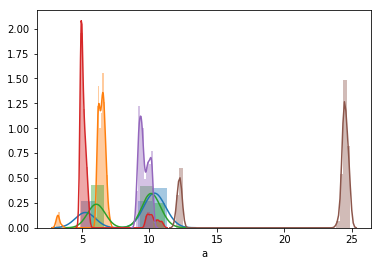

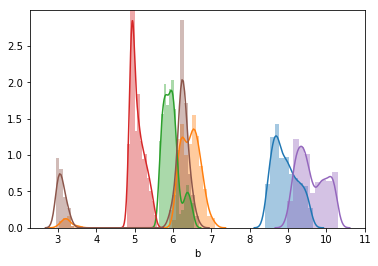

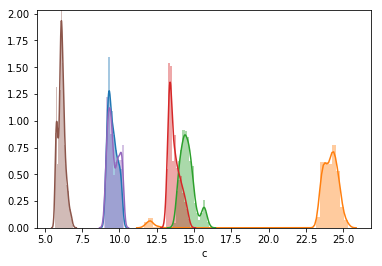

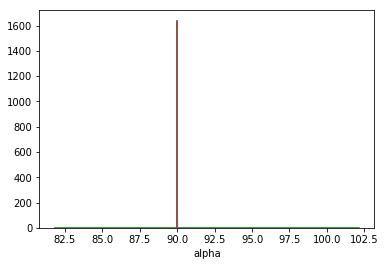

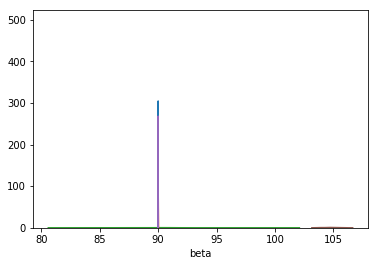

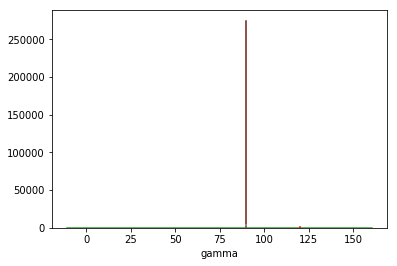

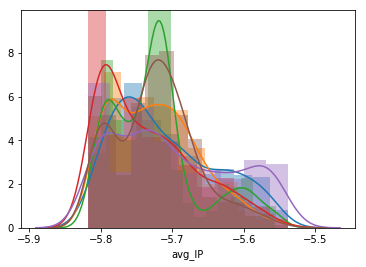

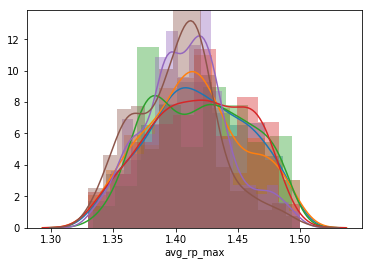

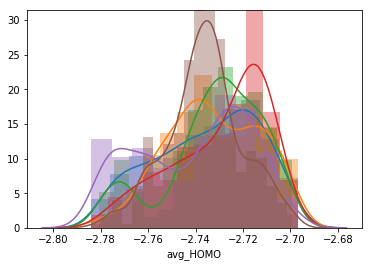

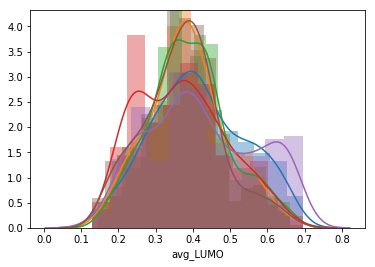

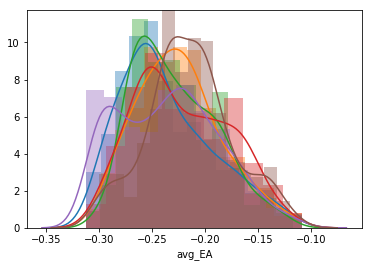

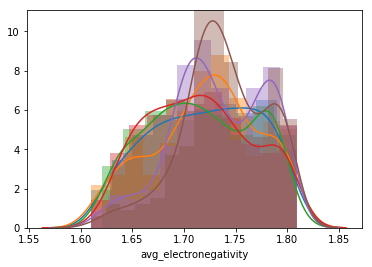

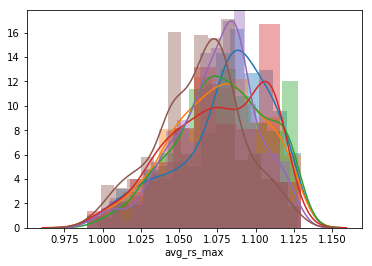

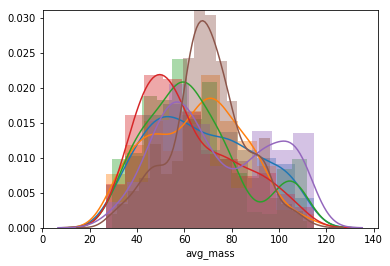

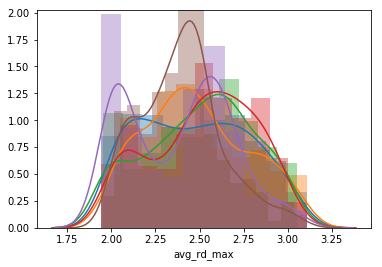

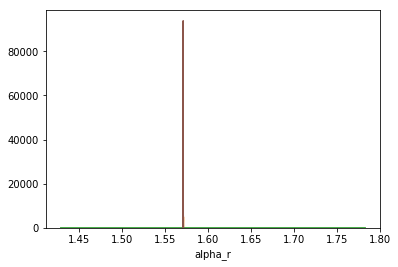

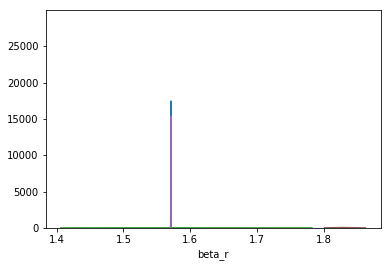

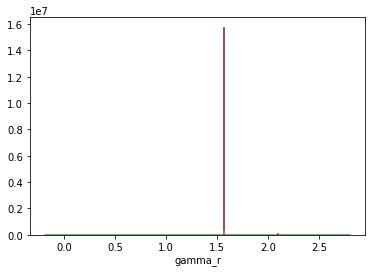

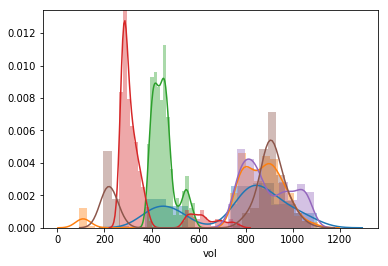

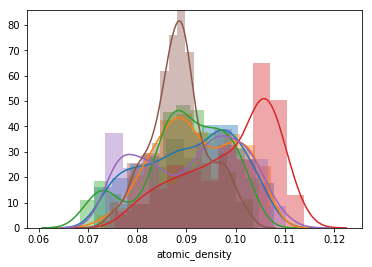

In [16]:
for col in all_data.columns.tolist()[1:]:
    for x in all_data.sg.unique():
        sns.distplot(all_data[all_data['sg'] == x][col])
    plt.show()

### Looking above, many features such as (a, b, c) have different distributions depending on their group
- You can do some simple feature engineering by grouping the training data and adding the mean for "co-grouped" numerical data
- This improved my score slightly

In [17]:
# make new features using averages of the following columns by sg group
avg_cols = ['x_Al','x_Ga','x_In','a','b','c','avg_rs_max','avg_electronegativity',
            'avg_rp_max','avg_LUMO','avg_IP','avg_rd_max','avg_EA','avg_HOMO',
            'avg_mass','vol','atomic_density']


for col in avg_cols:
    new_col = col + "_avg"
    all_data[new_col] = np.nan
    for group in all_data['sg'].unique():
        all_data.loc[(all_data['sg'] == group), new_col] = all_data[(all_data['sg'] == group)][col].mean()

print(pd.isnull(all_data).sum().sum())

0


### Correcting the distribution of the target variables
- Both of the target variables didn't have quite a normal distribution.
- I used the log1p function to fix this.
- Improved my score slightly

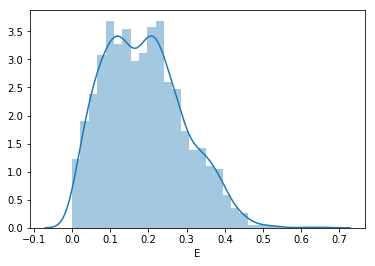

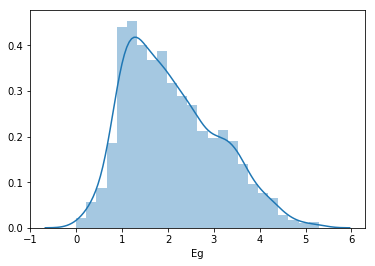

In [18]:
# both of the target variables are skewed a bit

for col in ['E', 'Eg']:
    sns.distplot((train[col]))
    plt.show()

### Preprocessing/skew correction for models

In [19]:
from sklearn.preprocessing import StandardScaler

# features to use
features = ['sg', 'Natoms','x_Al', 'x_Ga', 'x_In', 'a', 'b', 'c', 'alpha', 'beta',
            'gamma', 'vol', 'atomic_density', 'x_Al_avg','x_Ga_avg', 'x_In_avg', 'a_avg',
            'b_avg', 'c_avg', 'vol_avg', 'atomic_density_avg']

# scaling the data. Linear models tend to like more normally distributed
# I tried training on non-scaled, with slightly worse results
scale = StandardScaler()
scaled = scale.fit(all_data[features]).transform(all_data[features])

X_scale = scaled[:train.shape[0]]
X_scaled_test = scaled[train.shape[0]:]

X_tr = all_data[:train.shape[0]].values
X_te = all_data[train.shape[0]:].values

y1 = np.log1p(train['E'])
y2 = np.log1p(train['Eg'])

y12 = np.column_stack((y1, y2))

X_tr.shape, y1.shape, y2.shape, y12.shape

((2400, 42), (2400,), (2400,), (2400, 2))

### The performance metric for this competition

In [20]:
# performance matric
def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """    
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

# NN Model

### Standard Nerual Network Implimentation
- Use dense layers with Dropout / l2 regularization
- Used Keras for fast implimentation, but could use any framework you want
- Best RMSLE: 0.0577

In [21]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization, Input

Using TensorFlow backend.


In [22]:
def get_model(shape):
    """ Returns a model of specific shape
    """
    X_input = Input(shape=(shape,))
    
    X = Dense(64, activation='relu')(X_input)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.1)(X)
    
    X = Dense(64, activation='relu')(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.1)(X)
    
    X = Dense(64, activation='relu')(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.1)(X)
    
    X = Dense(64, activation='relu')(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.1)(X)
    
    X = Dense(64, activation='relu')(X)
    X = Dense(64, activation='relu')(X)
    X = Dense(2, activation='linear')(X)

    
    return Model(inputs=X_input, outputs=X)

# computes RMSLE from tensorflow
def rmsle_K(y, y0):
    return K.sqrt(K.mean(K.square(tf.log1p(tf.expm1(y)) - tf.log1p(tf.expm1(y0)))))

def compile_model(shape, lr=0.001):
    model = get_model(shape)
    optimizer = Adam(lr=lr, decay=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=[rmsle_K])
    return model

In [23]:
# uncomment below to train the model.

# out = []
# for idx, label in enumerate([0.002, 0.0022, 0.0024, 0.0026]):
#     model = compile_model(X_scale.shape[1], lr=label)
#     evl = model.fit(x=X_scale, y=y12, epochs=600, batch_size=16, verbose=2)
#     out.append(evl.history.get('rmsle_K'))
#     print(str(label) + " rmsle: {}".format(np.mean(out[idx][180:])))

In [24]:
# Will assess the model using cross validation.
# This will take a long time depending on your hardwear
def assess_nn(X, y, params):
    """ Used to access model performance. Returns the mean rmsle score of cross validated data
    """
    final = []
    best_iter = [[], []]
    kfold = KFold(n_splits=2, shuffle=True)
    out = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = compile_model(X_scale.shape[1], lr=0.003)
        model.fit(x=X_scale, y=y12, epochs=600, batch_size=16, verbose=0)
        h =  model.predict(X_test)
        e = rmsle(np.expm1(h), np.expm1(y_test))
        print(e)
        out.append(e)
    final.append(np.array(out).mean())
                      
    print('y1 best iteration: {}'.format(np.mean(best_iter[0])))
    print('y2 best iteration: {}'.format(np.mean(best_iter[1])))
    return(np.array(final).mean(), np.array(final).std())

In [25]:
# uncomment to access model

# model = access(X_scale, y12, params)
# print(model)

In [26]:
# if you run the access function above, use the plotting below to plot the last 40 rows of each kfold

# for x in out:
#     plt.plot(x[-40:])

# Graident Boosted Regression

### To find values for sklearn packages, I used sklearn-optimization for Baysian Optimization

- Easy implimentation of baysian optimization for sklearn-like model objects
- Multi-threaded, fast, and easy
- For more controll or other models not like sklearn, I like using another baysian optimization package found here: https://github.com/fmfn/BayesianOptimization

In [29]:
# I used skopt to cross validate models
# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

In [31]:
# uses baysian optimization to find model parameters

# model = GradientBoostingRegressor(
#     loss='ls',
#     learning_rate = 0.0035,
#     max_depth=23,
#     n_estimators=30275,
#     max_features=9,
#     min_samples_leaf=22,
#     min_samples_split=15,
#     min_weight_fraction_leaf=0.0102470171519909
# )

# search_params = {
#     "n_estimators": Integer(1000, 4000),
#     'max_depth': Integer(2, 40),
#     'min_samples_split': Integer(2, 15),
#     'min_samples_leaf': Integer(2, 50),
#     'min_weight_fraction_leaf': Real(0., .5),
#     'max_features': Integer(2, 13)
# }

# opt = BayesSearchCV(model, search_params, n_iter=50, n_jobs=8, )
# opt.fit(X_scale, y2)
# opt.best_params_

In [36]:
# run different model for different Target Variables

grad_1 = GradientBoostingRegressor(
                loss='ls',
                learning_rate = 0.0035,
                max_depth=7,
                n_estimators=1120,
                max_features=7,
                min_samples_leaf=43,
                min_samples_split=14,
                min_weight_fraction_leaf=0.01556)

grad_2 = GradientBoostingRegressor(
                loss='ls',
                learning_rate = 0.0035,
                max_depth=6,
                n_estimators=3275,
                max_features=2,
                min_samples_leaf=2,
                min_samples_split=2,
                min_weight_fraction_leaf=0.08012)

def assess_grad(X, y_list, model_list):
    """ Used to access model performance. Returns the mean rmsle score of cross validated data
    """
    final = []
    best_iter = [[], []]
    for idx, y in enumerate(y_list):
        kfold = KFold(n_splits=10, shuffle=True)
        out = []
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model = model_list[idx]
            model.fit(X_train, y_train)
            h =  model.predict(X_test)
            e = rmsle(np.expm1(h), np.expm1(y_test))
            print('Grad RMSLE: {}'.format(e))
            out.append(e)
        final.append(np.array(out).mean())
                      
    return(np.array(final).mean(), np.array(final).std())

In [37]:
model = assess_grad(X_tr, [y1, y2], [grad_1, grad_2])
print("RMSLE: {}, std: {}".format(model[0], model[1]))

RMSLE: 0.03138560720409071
RMSLE: 0.03419644647308396
RMSLE: 0.03122432075034315
RMSLE: 0.03242962915394718
RMSLE: 0.03494098386333039
RMSLE: 0.030861638901214204
RMSLE: 0.02962890129188151
RMSLE: 0.029324955385114673
RMSLE: 0.030124489239101736
RMSLE: 0.03844029762102037
RMSLE: 0.11082103587724987
RMSLE: 0.0809457343040868
RMSLE: 0.07775868609455819
RMSLE: 0.09361094757178191
RMSLE: 0.09084017074210986
RMSLE: 0.0839640470130055
RMSLE: 0.08920805603536154
RMSLE: 0.08105154787989838
RMSLE: 0.08455680037975684
RMSLE: 0.0825037295800392
RMSLE: 0.059890901268048795, std: 0.027635174279736004


## LightGbm model

### Light GBM is a Microsoft package, and great implimentation of a boosted tree model

- Created and maintained by Microsoft.
- Latest commits show a lot of activity
- Proven to be very fast and scalable
- Offers many more parameters for fine tuning models then similar approaches
- Has sklearn Like objects available 

In [38]:
import lightgbm as lgb
from lightgbm import Dataset

### Finding Parameters

- For boosted trees, I start by choosing a learning rate in (0.01, 0.001) range
- Use baysian optimization to find number of estimators for that learning rate. If man estimators are needed, use a larger learning rate
- Use baysian optimization ot find other parameters

In [39]:
# find useful parameters for model

# model = lgb.LGBMRegressor(
#                 objective= 'regression',
#                 boosting_type= 'gbdt',
#                 learning_rate= 0.002,
#                 num_boost_round = 2000,
#                 num_threads=1,
#                 bagging_fraction=0.50173,
#                 bagging_freq= 14,
#                 feature_fraction= 0.62509,
#                 lambda_l2= 0.0086298,
# #                 max_depth=10,
#                 num_leaves=196
#             )

search_params = {
#     'boosting_type': 'gbdt',
#         'objective': 'regression',
#         'metric': {'rmse', 'rmsle'},
#         'max_depth': Integer(20, 100),
#         'num_leaves': Integer(100, 200),
#         'learning_rate': 0.010,
#         'feature_fraction': Real(0.5, 1.),
#         'bagging_fraction': Real(0.5, 1),
#         'bagging_freq': Integer(5, 15),
#         'num_threads': -1,
#         'lambda_l2': Real(.00001, 0.01, 'log_normal'),
#          'lambda_l1': Real(.00001, 0.01, 'log_normal'),
#     'num_iterations': Integer(1000, 4000)
}

# opt = BayesSearchCV(model, search_params, n_iter=50, n_jobs=-1, verbose=0)
# opt.fit(X_scale, y1)
# opt.best_params_

In [40]:
# Run accessment using parameters found below

lgb_1 = lgb.LGBMRegressor(
                objective= 'regression',
                boosting_type= 'gbdt',
                learning_rate= 0.002,
                num_boost_round = 2000,
                num_threads=-1,
                bagging_fraction=0.56369,
                bagging_freq= 14,
                feature_fraction= 0.88868,
                lambda_l2= 0.0091689,
                max_depth=96,
                num_leaves=155)

lgb_2 = lgb.LGBMRegressor(
                objective= 'regression',
                boosting_type= 'gbdt',
                learning_rate= 0.002,
                num_boost_round = 2838,
                num_threads=-1,
                bagging_fraction=0.50173,
                bagging_freq= 14,
                feature_fraction= 0.62509,
                lambda_l2= 0.0086298,
                max_depth=20,
                num_leaves=196)

# This access uses the built in early stopping functions that make light gmb so great.

def assess_light(X, y_list, model_list):
    """ Used to access model performance. Returns the mean rmsle score of cross validated data
    """
    final = []
    best_iter = [[], []]
    for idx, y in enumerate(y_list):
        kfold = KFold(n_splits=10, shuffle=True)
        out = []
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model = model_list[idx]
            model.fit(X_train, y_train)
            h =  model.predict(X_test)
            e = rmsle(np.expm1(h), np.expm1(y_test))
            print(e)
            out.append(e)
        final.append(np.array(out).mean())
                      
    print('y1 best iteration: {}'.format(np.mean(best_iter[0])))
    print('y2 best iteration: {}'.format(np.mean(best_iter[1])))
    return(np.array(final).mean(), np.array(final).std())

model = assess_light(X_scale, [y1, y2], [lgb_1, lgb_2])
print(model)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


KeyboardInterrupt: 

### Light GBM also has a useful "early-stopping" option. The following access function will use this function

In [ ]:
def assess_early_stop(X, y_list, params):
    """ Used to access model performance. Returns the mean rmsle score of cross validated data
    """
    final = []
    best_iter = [[], []]
    for idx, y in enumerate(y_list):
        kfold = KFold(n_splits=10, shuffle=True)
        out = []
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_valid = lgb.Dataset(X_test, y_test, reference=lgb_train)
            model = lgb.train(params[idx],
                            lgb_train,
                            num_boost_round=1000000,
                            valid_sets=[lgb_valid],
                            early_stopping_rounds=200,
                            verbose_eval=0) 
            best_iter[idx].append(model.best_iteration)
            h =  model.predict(X_test, num_iteration=model.best_iteration)
            e = rmsle(np.expm1(h), np.expm1(y_test))
            print(e, model.best_iteration)
            out.append(e)
        final.append(np.array(out).mean())
                      
    print('y1 best iteration: {}'.format(np.mean(best_iter[0])))
    print('y2 best iteration: {}'.format(np.mean(best_iter[1])))
    return(np.array(final).mean(), np.array(final).std())

In [ ]:
params1 = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse', 'rmsle'},
            'max_depth': 10,
            'num_leaves': 40,
            'learning_rate': 0.010,
            'feature_fraction': 0.8632,
            'bagging_fraction': 0.8759,
            'bagging_freq': 4,
            'verbose': 0,
            'verbose_eval':0,
            'num_threads': -1,
            'lambda_l2': 0.0005597442104287973,
            'lambda_l1': 0.00015997163552092318 
        }

params2 = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'rmse', 'rmsle'},
            'learning_rate': 0.010,
            'verbose': 0,
            'verbose_eval':0,
            'num_threads': -1,
            'bagging_fraction': 0.9311539021934098,
             'bagging_freq': 15,
             'feature_fraction': 0.9989744117209727,
             'lambda_l1': 8.337666829263869e-05,
             'lambda_l2': 0.005541689229153562,
             'max_depth': 19,
             'num_leaves': 199
            
        }

model = assess_early_stop(X_scale, [y1, y2], [params1, params2])
print(model)

# XGBoost

### XGBoost is one of the most popular and successful boosting tree algorithms
- Available in many different languages
- Very fast and scalable
- Often wins many different Kaggle competions

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# find useful parameters for model

# model = XGBRegressor(
#     silent=True,
#     learning_rate= 0.0050,
#     n_jobs=1
# )

# search_params1 = {

#     'n_estimators': Integer(1804, 1806),
# #     'gamma': Real(0, 100),
#     'max_depth' : Integer(15, 100),
#     'min_child_weight': Integer(10, 1000),
#     'max_delta_step': Integer(1, 100),
#     'subsample': Real(0, 1),
#     'colsample_bytree': Real(0.0001, 1),
#     'colsample_bylevel': Real(0.0001, 1),
#     'reg_lambda': Real(0.000000001, 1.0),
# }

# xgb_params_1 = {
#     'learning_rate':0.005,
#     'n_jobs':-1,
#     'n_estimators': 1804,
#     'gamma': 0.0,
#     'subsample': 0.749700,
#     'colsample_bytree': 1.0,
#     'colsample_bylevel': 0.2790166932949295,
#     'max_delta_step': 1,
#     'max_depth': int(15),
#     'min_child_weight': 30,
#     'reg_lambda': 1e-09,
#     'silent': True,
#     'n_jobs': 8}

# search_params2 = {

#     'n_estimators': Integer(2383, 2400),
# #     'gamma': Real(0, 100),
#     'max_depth' : Integer(15, 100),
#     'min_child_weight': Integer(10, 100),
#     'max_delta_step': Integer(1, 200),
#     'subsample': Real(0, 1),
#     'colsample_bytree': Real(0.01, 1),
#     'colsample_bylevel': Real(0.01, 1),
#     'reg_lambda': Real(0.0000001, 0.5),
    
# }

# xgb_params_2 = {
#     'learning_rate':0.005,
#     'n_jobs':-1,
#     'n_estimators': 2383,
#     'colsample_bylevel': 0.982522,
#     'colsample_bytree': 1.0,
#     'gamma': 0.0,
#     'max_depth': 15,
#     'min_child_weight': 63,
#     'colsample_bytree': 0.4254153401195336,
#     'max_delta_step': 65,
#     'reg_lambda': 0.031165789070644215,
#     'subsample': 0.6831707073621087,
#     'silent':True,
#     'n_jobs':8,
# }

# for params, y, i in zip([search_params1, search_params2], [y1, y2], ['1', '2']):
#     opt = BayesSearchCV(model, params, n_iter=100, n_jobs=-1, verbose=0)
#     opt.fit(X_tr, y)
#     print('y' + i, opt.best_params_)

In [ ]:
xgb_1 = XGBRegressor(
    learning_rate=0.005,
    n_jobs=8,
    n_estimators= 1804,
    gamma= 0.0,
    subsample= 0.222159,
    colsample_bytree= 0.5359,
    colsample_bylevel= 0.19958,
    max_delta_step= 64,
    max_depth=28,
    min_child_weight= 10,
    reg_lambda=0.33038,
    silent= True,
)

xgb_2 = XGBRegressor(
    learning_rate=0.005,
    n_jobs=8,
    n_estimators= 2386,
    gamma= 0.0,
    subsample= 0.90919,
    colsample_bytree= 0.59049,
    colsample_bylevel= 0.59404,
    max_delta_step= 99,
    max_depth=58,
    min_child_weight= 85,
    reg_lambda= 0.031165789070644215,
    silent= True,
)
def assess_xgb(X, y_list, model_num, params):
    """ Used to access model performance. Returns the mean rmsle score of cross validated data
    """
    final = []
    best_iter = [[], []]
    for idx, y in enumerate(y_list):
        kfold = KFold(n_splits=10, shuffle=True)
        out = []
        for train_index, test_index in kfold.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model = model_num[idx]
            model.fit(X_train, y_train)
            h =  model.predict(X_test)
            e = rmsle(np.expm1(h), np.expm1(y_test))
            print(e)
            out.append(e)
        final.append(np.array(out).mean())
    return(np.array(final).mean(), np.array(final).std())

model = assess_xgb(X_tr, [y1, y2], [model_1, model_2], [xgb_params_1, xgb_params_2])
print(model)

## Stacked Models

### Model Stacking combines many models to improve accuracy

- Stacking Meta Models use 2 tiers
- First tier uses "base models" to predict y values
- Second tier uses "meta models" on the predicted values to as the final predictor

Find more information on this stacking approach, here is a great Kaggle blog about it: http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/

In [ ]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.base import clone

class StackingAveragedModels():
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
# stacking for y1
xgb_1 = XGBRegressor(
    learning_rate=0.005,
    n_jobs=8,
    n_estimators= 1804,
    gamma= 0.0,
    subsample= 0.222159,
    colsample_bytree= 0.5359,
    colsample_bylevel= 0.19958,
    max_delta_step= 64,
    max_depth=28,
    min_child_weight= 10,
    reg_lambda=0.33038,
    silent= True)

lgb_1 = lgb.LGBMRegressor(
                objective= 'regression',
                boosting_type= 'gbdt',
                learning_rate= 0.002,
                num_boost_round = 2000,
                num_threads=-1,
                bagging_fraction=0.56369,
                bagging_freq= 14,
                feature_fraction= 0.88868,
                lambda_l2= 0.0091689,
                max_depth=96,
                num_leaves=155)

grad_1 = GradientBoostingRegressor(
                loss='ls',
                learning_rate = 0.0035,
                max_depth=7,
                n_estimators=1120,
                max_features=7,
                min_samples_leaf=43,
                min_samples_split=14,
                min_weight_fraction_leaf=0.01556)
lasso = Lasso(alpha=0.001)
linear = LinearRegression()


stacked_1 = StackingAveragedModels(base_models=[xgb_1, lgb_1, grad_1], meta_model=linear)
stack_1 = stacked_1.fit(X_scale, y1)

In [ ]:
lgb_2 = lgb.LGBMRegressor(
                objective= 'regression',
                boosting_type= 'gbdt',
                learning_rate= 0.002,
                num_boost_round = 2838,
                num_threads=-1,
                bagging_fraction=0.50173,
                bagging_freq= 14,
                feature_fraction= 0.62509,
                lambda_l2= 0.0086298,
                max_depth=20,
                num_leaves=196)

grad_2 = GradientBoostingRegressor(
                loss='ls',
                learning_rate = 0.0035,
                max_depth=6,
                n_estimators=3275,
                max_features=2,
                min_samples_leaf=2,
                min_samples_split=2,
                min_weight_fraction_leaf=0.08012)

xgb_2 = XGBRegressor(
    learning_rate=0.005,
    n_jobs=8,
    n_estimators= 2386,
    gamma= 0.0,
    subsample= 0.90919,
    colsample_bytree= 0.59049,
    colsample_bylevel= 0.59404,
    max_delta_step= 99,
    max_depth=58,
    min_child_weight= 85,
    reg_lambda= 0.031165789070644215,
    silent= True,
)

stacked_2 = StackingAveragedModels(base_models=[xgb_2, lgb_2, grad_2], meta_model=linear)
stack_2 = stacked_2.fit(X_scale, y2)

# Create Submission


In [ ]:
one = stack_1.predict(X_scaled_test)
two = stack_2.predict(X_scaled_test)
_id = test['id']

submit = pd.DataFrame({'id':_id,
                       'formation_energy_ev_natom':np.expm1(one).flatten(),
                       'bandgap_energy_ev':np.expm1(two).flatten()})

In [ ]:
submit.head()

In [ ]:
submit.to_csv('submission.csv', index=False)